# D209 Task 2: Decision Tree Regressor
### By Chase Whitman

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Set pandas option to view all columns
pd.set_option('display.max_columns', None)

## Read in data

In [2]:
df = pd.read_csv(r"C:\Users\chase\OneDrive\Documents\WGU\Courses\D208\churn_clean.csv")

In [3]:
df.shape

(10000, 50)

In [4]:
df.columns

Index(['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
       'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone', 'Job',
       'Children', 'Age', 'Income', 'Marital', 'Gender', 'Churn',
       'Outage_sec_perweek', 'Email', 'Contacts', 'Yearly_equip_failure',
       'Techie', 'Contract', 'Port_modem', 'Tablet', 'InternetService',
       'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod', 'Tenure', 'MonthlyCharge',
       'Bandwidth_GB_Year', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5',
       'Item6', 'Item7', 'Item8'],
      dtype='object')

## Data Preprocessing

In [5]:
print('Shape of dataframe:')
print('Before drop:', df.shape)

# Drop columns that contain unique values
unique_columns = ['CaseOrder', 'Customer_id', 'Interaction', 'UID']

# Multiple columns are used to decribe location. Timezone will be used as a regional reference.
# The additional location columns will be dropped.
location_columns = ['City', 'State','County', 'Zip', 'Lat', 'Lng', 'Job']

# Apply the drop
df.drop(columns=(unique_columns+location_columns), inplace=True)

print('After drop:', df.shape)

Shape of dataframe:
Before drop: (10000, 50)
After drop: (10000, 39)


In [6]:
# Columns that contain binary values (Y/N)
binary_columns = ['Churn', 'Techie', 'Port_modem', 'Tablet', 'Phone', 'Multiple', 
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                  'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

# Convert values to 1s/0s
for col in binary_columns:
    df[col] = df[col].map(dict(Yes=1, No=0))

# Examine results
df[binary_columns].head()

,Churn,Techie,Port_modem,Tablet,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling
0,0,0,1,1,1,0,1,1,0,0,0,1,1
1,1,1,0,1,1,1,1,0,0,0,1,1,1
2,0,1,1,0,1,1,0,0,0,0,0,1,1
3,0,1,0,0,1,0,1,0,0,0,1,0,1
4,1,0,1,0,0,0,0,0,0,1,1,0,0


In [7]:
# One hot encode columns with multiple unique values
dummy_columns = ['Area', 'TimeZone']
df = pd.get_dummies(df, columns=dummy_columns, drop_first=True)

In [8]:
# One hot encode Internet Service based on Fiber Optic and DSL values
df['InternetService_FiberOptic'] = np.where(df.InternetService == 'Fiber Optic', 1, 0)
df['InternetService_DSL'] = np.where(df.InternetService == 'DSL', 1, 0)

# Examine results
print(df[['InternetService', 'InternetService_DSL', 'InternetService_FiberOptic']].head(8))

# Drop original Internet Service column
df.drop(columns='InternetService', inplace=True)

  InternetService  InternetService_DSL  InternetService_FiberOptic
0     Fiber Optic                    0                           1
1     Fiber Optic                    0                           1
2             DSL                    1                           0
3             DSL                    1                           0
4     Fiber Optic                    0                           1
5            None                    0                           0
6             DSL                    1                           0
7             DSL                    1                           0


In [9]:
# One hot encode Gender based on Male and Female
df['Gender_Male'] = np.where(df.Gender == 'Male', 1, 0)
df['Gender_Female'] = np.where(df.Gender == 'Female', 1, 0)

# Examine results
print(df[['Gender', 'Gender_Male', 'Gender_Female']].head(10))

# Drop original Gender column
df.drop(columns='Gender', inplace=True)

      Gender  Gender_Male  Gender_Female
0       Male            1              0
1     Female            0              1
2     Female            0              1
3       Male            1              0
4       Male            1              0
5     Female            0              1
6       Male            1              0
7     Female            0              1
8  Nonbinary            0              0
9     Female            0              1


In [10]:
# Reduce Marital categories into two types: 
#   Married:1 
#   Not Married:0
df['Marital'] = np.where(df.Marital == 'Married',1,0)

In [11]:
# One hot encode Payment Method based on automatic payments or checks
df['PaymentMethod_Auto'] = np.where(np.logical_or(df.PaymentMethod == 'Credit Card (automatic)', 
                       df.PaymentMethod == 'Bank Transfer(automatic)'), 1, 0)
df['PaymentMethod_Check'] = np.where(np.logical_or(df.PaymentMethod == 'Mailed Check', 
                       df.PaymentMethod == 'Electronic Check'), 1, 0)

# Examine results
print(df[['PaymentMethod', 'PaymentMethod_Auto', 'PaymentMethod_Check']].head(8))

# Drop original Payment Method column
df.drop(columns='PaymentMethod', inplace=True)

              PaymentMethod  PaymentMethod_Auto  PaymentMethod_Check
0   Credit Card (automatic)                   1                    0
1  Bank Transfer(automatic)                   1                    0
2   Credit Card (automatic)                   1                    0
3              Mailed Check                   0                    1
4              Mailed Check                   0                    1
5          Electronic Check                   0                    1
6          Electronic Check                   0                    1
7              Mailed Check                   0                    1


In [12]:
# Convert Contract type into numerical values based on the year value
df['Contract'] = df['Contract'].replace({'Month-to-month':0, 'One year':1, 'Two Year':2})

In [13]:
# Examine Results
df.head()

,Population,Children,Age,Income,Marital,Churn,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Techie,Contract,Port_modem,Tablet,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Tenure,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Area_Suburban,Area_Urban,TimeZone_America/Boise,TimeZone_America/Chicago,TimeZone_America/Denver,TimeZone_America/Detroit,TimeZone_America/Indiana/Indianapolis,TimeZone_America/Indiana/Knox,TimeZone_America/Indiana/Marengo,TimeZone_America/Indiana/Petersburg,TimeZone_America/Indiana/Tell_City,TimeZone_America/Indiana/Vincennes,TimeZone_America/Indiana/Winamac,TimeZone_America/Juneau,TimeZone_America/Kentucky/Louisville,TimeZone_America/Los_Angeles,TimeZone_America/Menominee,TimeZone_America/New_York,TimeZone_America/Nome,TimeZone_America/North_Dakota/New_Salem,TimeZone_America/Ojinaga,TimeZone_America/Phoenix,TimeZone_America/Puerto_Rico,TimeZone_America/Sitka,TimeZone_America/Toronto,TimeZone_Pacific/Honolulu,InternetService_FiberOptic,InternetService_DSL,Gender_Male,Gender_Female,PaymentMethod_Auto,PaymentMethod_Check
0,38,0,68,28561.99,0,0,7.978323,10,0,1,0,1,1,1,1,0,1,1,0,0,0,1,1,6.795513,172.455519,904.536110,5,5,5,3,4,4,3,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
1,10446,1,27,21704.77,1,1,11.699080,12,0,1,1,0,0,1,1,1,1,0,0,0,1,1,1,1.156681,242.632554,800.982766,3,4,3,3,4,3,4,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
2,3735,4,50,9609.57,0,0,10.752800,9,0,1,1,2,1,0,1,1,0,0,0,0,0,1,1,15.754144,159.947583,2054.706961,4,4,2,4,4,3,3,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
3,13863,1,48,18925.23,1,0,14.913540,15,2,0,1,2,0,0,1,0,1,0,0,0,1,0,1,17.087227,119.956840,2164.579412,4,4,4,2,5,4,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
4,11352,0,83,40074.19,0,1,8.147417,16,2,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1.670972,149.948316,271.493436,4,4,4,3,4,4,4,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1


## Split data

In [14]:
X = df.drop('Tenure',1).values
y = df['Tenure'].values

In [15]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.3, 
                                                            random_state=42)
print('Training data: X:{}, y:{}'.format(X_train.shape, y_train.shape))
print('Test data: X:{}, y:{}'.format(X_test.shape, y_test.shape))

Training data: X:(7000, 65), y:(7000,)
Test data: X:(3000, 65), y:(3000,)


## Decision Tree Regression

In [16]:
# Create pipeline steps
steps = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LassoCV())),
    ('regressor', DecisionTreeRegressor(random_state=101))
])
# Define grid search parameters
parameters = {'regressor__max_depth': np.arange(1,100)}

grid_dtr = GridSearchCV(steps, parameters)
grid_dtr.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LassoCV(alphas=None,
                                                                          copy_X=True,
                                                                          cv=None,
                                                                          eps=0.001,
                                                                          fit_intercept=True,
                                                                          max_iter=1000,
                                                                       

In [17]:
# Evaluate grid search parameter results
fs = grid_dtr.best_estimator_.named_steps['feature_selection']
features_names = df.drop(columns='Tenure').columns.to_list()
features = np.array(features_names)
selected_features = features[fs.get_support()]
print('The feature selection step eliminated {} features from the model.'.format(len(features_names) - len(selected_features)))
print('The following features were selected:\n', selected_features)

print('\nThe grid search determined that a max_depth value of {} produces the best model.'.format(
grid_dtr.best_estimator_.named_steps['regressor'].max_depth))

The feature selection step eliminated 50 features from the model.
The following features were selected:
 ['Children' 'Age' 'Churn' 'Multiple' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies'
 'MonthlyCharge' 'Bandwidth_GB_Year' 'InternetService_FiberOptic'
 'InternetService_DSL' 'Gender_Male']

The grid search determined that a max_depth value of 20 produces the best model.


## Model Evaluation

In [18]:
def print_results(predictions):
    print('MAE: {}'.format(mean_absolute_error(y_test, predictions)))
    print('MSE: {}'.format(mean_squared_error(y_test, predictions)))
    print('R-squared: {}'.format(r2_score(y_test, predictions)))

In [19]:
# Make predictions and print results
y_pred = grid_dtr.predict(X_test)

print_results(y_pred)

MAE: 1.2116752897305
MSE: 2.374297928887092
R-squared: 0.9965907133238714


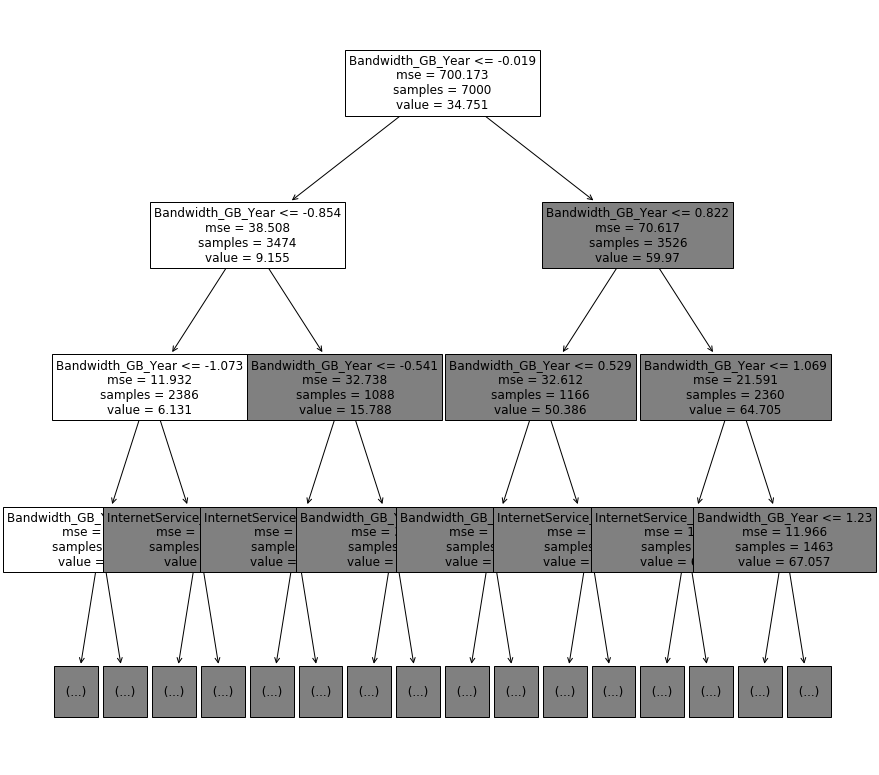

In [20]:
# Plot decision tree
plt.figure(figsize=(14,14))
plot_tree(grid_dtr.best_estimator_.named_steps['regressor'], 
          max_depth=3, feature_names=selected_features, fontsize=12)
plt.show()

### Export datsets to Excel

In [21]:
# Create training set dataframe
# df_train = pd.DataFrame(data=X_train_raw, columns=df.drop('Churn',1).columns)
# df_train['Churn'] = pd.Series(y_train)

# Create test set dataframe
# df_test = pd.DataFrame(data=X_test_raw, columns=df.drop('Churn',1).columns)
# df_test['Churn'] = pd.Series(y_test)

In [22]:
# Export each dataframe to excel on different sheets
# writer = pd.ExcelWriter(r'C:\Users\chase\OneDrive\Documents\WGU\Courses\D209\D209_datsets.xlsx', engine='xlsxwriter')
# frames = {'Cleaned full': df,
#          'Training set': df_train,
#          'Test set': df_test}
# for sheet, frame in frames.items():
#     frame.to_excel(writer, sheet_name=sheet)
# writer.save()